# Information Leakage Detection Tutorial

Information leakage can lead to overly optimistic model performance, as the model might "cheat" by learning information it shouldn't have access to. This tutorial will generate synthetic datasets and simulate different information leakage scenarios using controlled noise. We will then detect leakage using RandomForest.

## Steps:
1. Synthetic dataset generation and visualization
2. Using TabPFN leakage detectors.
3. Analyzing detection results.

In [1]:
import logging
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("pytorch").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)

In [2]:
from autoqild.detectors import TabPFNLeakageDetector, RandomForestLeakageDetector
from autoqild.dataset_readers import SyntheticDatasetGeneratorDistance
from utils import setup_logging, setup_random_seed, create_search_space

2024-08-16 20:25:20.011435: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 20:25:20.014044: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 20:25:20.047287: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 20:25:20.683385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Setting Up Experiment Logging and Random Seed:**

Initialize logging for the experiment, recording all key events in info_leakage_detection.log for tracking and debugging.

In [3]:
logger = setup_logging(log_path='info_leakage_detection.log')
logger = logging.getLogger("ILD-Experiment")
setup_random_seed(42)
# Log some messages
logger.info('Logger initialized and ready.')
logger.info('Running the vulnerability detection process...')

### Step 1: Generate Synthetic Datasets

Create two datasets:
- **Vulnerable Dataset:** High noise level leading to significant overlap between classes.
- **Non-Vulnerable Dataset:** Low noise level leading to clear separation between classes.

In [4]:
# Generating datasets with varying noise levels to simulate vulnerable and non-vulnerable systems.
n_classes=2
n_features=2
# Vulnerable dataset with high noise (leakage present)
dataset_params = {'n_classes':n_classes, 'n_features': n_features, 'samples_per_class': 200,'random_state':42}
dataset_params['noise'] = 0.1

generator_vulnerable = SyntheticDatasetGeneratorDistance(**dataset_params)
X_vulnerable, y_vulnerable = generator_vulnerable.generate_dataset()

dataset_params['noise'] = 1.0
# Non-vulnerable dataset with low noise (minimal leakage)
generator_non_vulnerable = SyntheticDatasetGeneratorDistance(**dataset_params)
X_non_vulnerable, y_non_vulnerable = generator_non_vulnerable.generate_dataset()


### Step 2: Visualize the Datasets

**Visualizing** the datasets using the scatter plots helps us see the differences in class separability for datasets simulating vulnerable and non-vulnerable systems. 

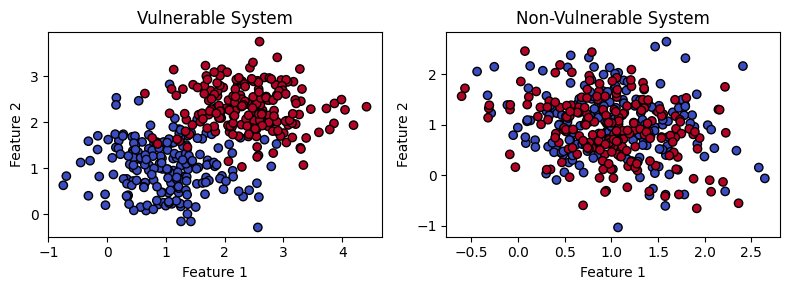

In [5]:
import matplotlib.pyplot as plt

def plot_datasets(X1, y1, title1, X2, y2, title2):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    # Plot the first dataset
    axes[0].scatter(X1[:, 0], X1[:, 1], c=y1, cmap='coolwarm', edgecolor='k')
    axes[0].set_title(title1)
    axes[0].set_xlabel("Feature 1")
    axes[0].set_ylabel("Feature 2")

    # Plot the second dataset
    axes[1].scatter(X2[:, 0], X2[:, 1], c=y2, cmap='coolwarm', edgecolor='k')
    axes[1].set_title(title2)
    axes[1].set_xlabel("Feature 1")
    axes[1].set_ylabel("Feature 2")

    plt.tight_layout()
    plt.show()

# Plotting both datasets side by side
plot_datasets(X_vulnerable, y_vulnerable, "Vulnerable System", X_non_vulnerable, y_non_vulnerable, "Non-Vulnerable System")

### Step 3: Initializing and Fitting the TabPFN Detectors

We initialize the TabPFN detectors and fit them to both the vulnerable and non-vulnerable datasets.

In [6]:
# Common parameters for detectors
learner_params = {'model_type': 'default'}
fit_params = {}
cv_iterations = 3
base_directory = "./tabpfn"
search_space = {}
n_inner_folds = 3
validation_loss = "accuracy"
random_state = 42
detection_method = "log_loss_mi"
learner_params = {"n_ensembles": 100, "n_classes":n_classes, "n_features":n_features}
hp_ranges = {"n_ensembles": [32, 200], "n_reduced": [5, 20], "reduction_technique": ["select_from_model_et", "select_from_model_rf"]}
hp_iters = 5
n_hypothesis = 3
fit_params = {}
search_space = create_search_space(hp_ranges, logger)
# Initializing TabPFN and AutoGluon Detectors

padding_name = "synthetic_vulnerable"
hash_value =f"{padding_name}_hash_value"

tabpfn_detector_v = TabPFNLeakageDetector(padding_name=padding_name, learner_params=learner_params, fit_params=fit_params, 
                                        hash_value=hash_value, cv_iterations=cv_iterations, n_hypothesis=n_hypothesis, 
                                        hp_ranges = hp_ranges, detection_method=detection_method, 
                                        base_directory=base_directory, search_space=search_space,
                                        hp_iters=hp_iters, n_inner_folds=n_inner_folds, validation_loss=validation_loss, 
                                        random_state=random_state)
tabpfn_detector_v.fit(X_vulnerable, y_vulnerable)

padding_name = "synthetic_non_vulnerable"
hash_value =f"{padding_name}_hash_value"
tabpfn_detector_nv = TabPFNLeakageDetector(padding_name=padding_name, learner_params=learner_params, fit_params=fit_params, 
                                        hash_value=hash_value, cv_iterations=cv_iterations, n_hypothesis=n_hypothesis, 
                                        hp_ranges = hp_ranges, detection_method=detection_method, 
                                        base_directory=base_directory, search_space=search_space,
                                        hp_iters=hp_iters, n_inner_folds=n_inner_folds, validation_loss=validation_loss, 
                                        random_state=random_state)
tabpfn_detector_nv.fit(X_non_vulnerable, y_non_vulnerable)

### Step 4: Detecting Information Leakage Using Different Approaches

Since the detectors have already been fitted, we can directly apply different methods to detect leakage without refitting each time.

In [7]:
# Cell 5: Detecting Information Leakage Using Different Approaches
def run_detection(detector, method):
    detector.detection_method = method
    decision, rejected_hypotheses = detector.detect(detection_method=method)
    print(f"Detection Method: {method}")
    print(f"Detection Decision: {'Leakage Detected' if decision else 'No Leakage Detected'}")
    print(f"Hypotheses Rejected: {rejected_hypotheses}\n")

methods = ["fishers-exact-median", "paired-t-test-random", "log_loss_mi", "log_loss_mi_isotonic_regression", "mid_point_mi"]

print("###############################################################")
# Detecting for Vulnerable Dataset
print("Vulnerable System Detection Results with TabPFN Detector:\n")
for method in methods:
    run_detection(tabpfn_detector_v, method)

print("###############################################################")
# Detecting for Non-Vulnerable Dataset
print("Non-Vulnerable System Detection Results with TabPFN Detector:\n")
for method in methods:
    run_detection(tabpfn_detector_nv, method)

###############################################################
Vulnerable System Detection Results with TabPFN Detector:

Detection Method: fishers-exact-median
Detection Decision: Leakage Detected
Hypotheses Rejected: 3

Detection Method: paired-t-test-random
Detection Decision: Leakage Detected
Hypotheses Rejected: 3

Detection Method: log_loss_mi
Detection Decision: Leakage Detected
Hypotheses Rejected: 3

Detection Method: log_loss_mi_isotonic_regression
Detection Decision: Leakage Detected
Hypotheses Rejected: 3

Detection Method: mid_point_mi
Detection Decision: No Leakage Detected
Hypotheses Rejected: 0

###############################################################
Non-Vulnerable System Detection Results with TabPFN Detector:

Detection Method: fishers-exact-median
Detection Decision: No Leakage Detected
Hypotheses Rejected: 0

Detection Method: paired-t-test-random
Detection Decision: No Leakage Detected
Hypotheses Rejected: 0

Detection Method: log_loss_mi
Detection Decisio